In [28]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label
from keras.models import load_model
from rasterio.features import shapes
patchsize=128 #image should have multiple of 2 like 512 sth otherwise last row wont be shown
overlap=24
nbands=3


In [29]:
import rasterio
import tensorflow as tf
image_data = rasterio.open("test_image.tiff") #image that you use to predict
bands = [image_data.read(i+1) for i in range(nbands)]
Xuse=np.stack(bands,axis=2) #change this axis as you need to make the shape if channels are in first make it 0
NROWS, NCOLS, NBANDS = Xuse.shape
Xuse = np.expand_dims(Xuse, axis=0)
print(Xuse.shape)
model = tf.keras.models.load_model("YOURMODEL.hdf5",compile=False) #load your model as in pytorch

(1, 3200, 3200, 4)


In [30]:
_,Nrows,Ncols,NBands=Xuse.shape
if Ncols%patchsize!=0 or Nrows%patchsize!=0:
    print("The shape of input image is not divisible by patch size removing last pixels")
    newrow=int(Nrows/patchsize)
    newcol=int(Ncols/patchsize)
    Xuse=Xuse[:,:newrow*patchsize,:newcol*patchsize,:]
    print(f"the shape of new image is {Xuse.shape}")
_,Nrows,Ncols,NBands=Xuse.shape
itrcol=int((Ncols-patchsize)/(patchsize-overlap))+1
itrrow=int((Nrows-patchsize)/(patchsize-overlap))+1
totalmap=np.zeros((Nrows,Ncols),dtype=np.float32)
halfoverlap=int((overlap/2))
print(itrcol,itrrow)
for i in range(itrrow):
    if i ==0:
        striptop=i
        stripbottom=patchsize
        #print(striptop,stripbottom)
    else:
        striptop=(patchsize-overlap)*i
        stripbottom=(patchsize-overlap)*i+patchsize
    for j in range(itrcol):
        if j==0:
            stripleft=j
            stripright=patchsize
        else:
            stripleft=(patchsize-overlap)*j
            stripright=(patchsize-overlap)*j+patchsize
        Xuse_sub=Xuse[:,striptop:stripbottom,stripleft:stripright,:]
        predictions=model.predict_on_batch(Xuse_sub) #this is predict function check how is done in pytorch
        
        if i==0: 
            filltop=int(i)
            fillbottom=int((patchsize-overlap/2))
            if j==0:
                fillleft=int(j)
                fillright=int((patchsize-overlap/2))  
                totalmap[filltop:fillbottom,fillleft:fillright]=np.argmax(predictions[:,:-halfoverlap,:-halfoverlap,:][0],axis=2)#np.squeeze(np.squeeze(predictions[:,:-halfoverlap,:-halfoverlap,:], axis=3),axis=0)
            else:
                fillleft=int((patchsize-overlap/2)+(patchsize-overlap)*(j-1))
                fillright=int((patchsize-overlap/2)+(patchsize-overlap)*j)
                totalmap[filltop:fillbottom,fillleft:fillright]=np.argmax(predictions[:,:-halfoverlap,halfoverlap:-halfoverlap,:][0],axis=2)#np.squeeze(np.squeeze(predictions[:,:-halfoverlap,halfoverlap:-halfoverlap,:], axis=3),axis=0)
        else:
            filltop=int((patchsize-overlap/2)+(patchsize-overlap)*(i-1))
            fillbottom=int((patchsize-overlap/2)+(patchsize-overlap)*i)
            if j==0:
                fillleft=int(j)
                fillright=int((patchsize-overlap/2))  
                totalmap[filltop:fillbottom,fillleft:fillright]=np.argmax(predictions[:,halfoverlap:-halfoverlap,:-halfoverlap,:][0],axis=2)#np.squeeze(np.squeeze(predictions[:,halfoverlap:-halfoverlap,:-halfoverlap,:], axis=3),axis=0)
            else:
                fillleft=int((patchsize-overlap/2)+(patchsize-overlap)*(j-1))
                fillright=int((patchsize-overlap/2)+(patchsize-overlap)*j)
                totalmap[filltop:fillbottom,fillleft:fillright]=np.argmax(predictions[:,halfoverlap:-halfoverlap,halfoverlap:-halfoverlap,:][0],axis=2)#np.squeeze(np.squeeze(predictions[:,halfoverlap:-halfoverlap,halfoverlap:-halfoverlap,:], axis=3),axis=0)
        

30 30


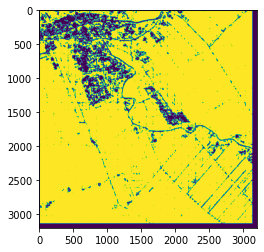

In [31]:
import matplotlib.pyplot as plt
plt.imshow(totalmap)
predictions=totalmap #plot results

In [26]:
save_file="outname.tif" ##Give the save name to save predicted data in here 
with rasterio.Env():
    profile = image_data.profile
    profile.update(
        dtype=rasterio.int8,
        count=1,
        width= predictions.shape[-1], 
        height= predictions.shape[-2],
        transform= image_data.transform *image_data.transform.scale(0.25,0.25),
        compress='lzw')
    with rasterio.open(save_file, 'w', **profile) as dst:
        dst.write(predictions.astype(rasterio.int8), 1)